In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/MuraDataset')

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img
# from keras_preprocessing.image import ImageDataGenerator,load_img
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split

In [4]:
os.listdir("/content/drive/MyDrive/MuraDataset/MURA-v1.1")

['train_labeled_studies.csv',
 'valid_labeled_studies.csv',
 'train_image_paths.csv',
 'valid_image_paths.csv',
 'train_images_display_copy.csv',
 'train_images_display.csv',
 'valid',
 'train']

In [5]:
# Train set studies with labels
df=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/train_labeled_studies.csv', names=['Train_Image','Train_Label'])

In [6]:
df.head()

,Train_Image,Train_Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [7]:
# Adding labels to individual images in train set
df1=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/train_image_paths.csv', names=['Train_Image'])
df1 = df1[df1['Train_Image'].str.split('/').str[2]== 'XR_ELBOW']
names=df1['Train_Image'].values


In [8]:
train_labels=[]

for i in names:
    if ('positive' in i):
        train_labels.append('1')
    elif('negative' in i):
        train_labels.append('0')

train_labels = np.array(train_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df1.insert(1, 'Train_Label', train_labels)

In [9]:
print(train_labels)

['1' '1' '1' ... '0' '0' '0']


In [10]:
df1.head()

,Train_Image,Train_Label
14757,MURA-v1.1/train/XR_ELBOW/patient04903/study1_p...,1
14758,MURA-v1.1/train/XR_ELBOW/patient04904/study1_p...,1
14759,MURA-v1.1/train/XR_ELBOW/patient04904/study1_p...,1
14760,MURA-v1.1/train/XR_ELBOW/patient04905/study1_p...,1
14761,MURA-v1.1/train/XR_ELBOW/patient04905/study1_p...,1


In [11]:
df1.shape

(4931, 2)

In [12]:
df1['Train_Image'] = '/content/drive/MyDrive/MuraDataset/' + df1['Train_Image']

In [13]:
df1.to_csv('Train_set.csv', index=False)

In [14]:
#Validation set studies with labels
df_valid=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/valid_labeled_studies.csv', names=['Valid_Image','Valid_Label'])

In [15]:
df_valid.head()

,Valid_Image,Valid_Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [16]:
# Adding labels to individual images in validation set
df_valid1=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/valid_image_paths.csv', names=['Valid_Image'])
df_valid1 = df_valid1[df_valid1['Valid_Image'].str.split('/').str[2]== 'XR_ELBOW']
names=df_valid1['Valid_Image'].values
valid_labels=[]

for i in names:
  if ('positive' in i):
    valid_labels.append('1')
  elif('negative' in i):
    valid_labels.append('0')

valid_labels = np.array(valid_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df_valid1.insert(1, 'Valid_Label', valid_labels)
df_valid1.to_csv('Valid_set.csv', index=False)

In [17]:
df_valid1.head()

,Valid_Image,Valid_Label
2271,MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...,1
2272,MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...,1
2273,MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...,1
2274,MURA-v1.1/valid/XR_ELBOW/patient11802/study1_p...,1
2275,MURA-v1.1/valid/XR_ELBOW/patient11802/study1_p...,1


In [18]:
df_valid1.shape

(465, 2)

In [19]:
df_valid1['Valid_Image'] = '/content/drive/MyDrive/MuraDataset/' + df_valid1['Valid_Image']
df_valid1.to_csv('Valid_set.csv', index=False)

In [20]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set.csv", dtype=str)
# valid_df = pd.read_csv("./Valid_set.csv", dtype=str)

In [21]:
valid_df = pd.read_csv("./Valid_set.csv", dtype=str)

In [22]:
train_df_part = train_df[500:4500]
print(len(train_df_part))

4000


In [23]:
train_data, test_data = train_test_split(train_df_part, test_size=0.1,random_state=10,stratify = train_df_part['Train_Label'])

In [24]:
train_samples = pd.DataFrame(train_data)
test_samples = pd.DataFrame(test_data)

In [25]:
print(len(train_samples))
print(len(test_samples))

3600
400


In [26]:
# Import DenseNet169 pre-trained model
dense_model = DenseNet169(include_top=False, weights='imagenet',pooling = 'avg')

51888128/51877672 [==============================] - 1s 0us/step


In [27]:
#Freeze the layers
dense_model.trainable = False

In [28]:
for layer in dense_model.layers[586:]:
    layer.trainable = True

    
for layer in dense_model.layers:
    print(layer,layer.trainable)     

<keras.engine.input_layer.InputLayer object at 0x7fc1a97600d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fc1a5c2ead0> False
<keras.layers.convolutional.Conv2D object at 0x7fc1a7347210> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fc1a5eaca90> False
<keras.layers.core.Activation object at 0x7fc1a5c2e390> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fc1a5eac750> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc1a5de0b50> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fc1a5e1dc10> False
<keras.layers.core.Activation object at 0x7fc1a5de0990> False
<keras.layers.convolutional.Conv2D object at 0x7fc1a5ddedd0> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fc1a5df4350> False
<keras.layers.core.Activation object at 0x7fc1a5debb90> False
<keras.layers.convolutional.Conv2D object at 0x7fc1a5de03d0> False
<keras.layers.merge.Concatenate object at 0x7fc1a5dfee50> False
<keras.layers.norma

In [29]:
predictions = Dense(1, activation='sigmoid')(dense_model.layers[-1].output)
model = Model(inputs=dense_model.input, outputs=predictions)

In [30]:
filepath = '/content/drive/MyDrive/MuraDataset/'
model.load_weights(filepath+'bestmodel/elbowmodel-00006-0.19413-0.80278-0.21183-0.80000.h5',by_name = True)

In [31]:
import cv2
def get_testdata():
    image_data = []
    x_data = []
    y_data = []
    for index, row in test_samples.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [32]:
testx1,testy1 = get_testdata()
print(testx1.shape)
print(testy1.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(400, 300, 300, 3)
(400,)


In [33]:
testy1 = list(map(int, testy1))

In [34]:
# predict probabilities for test set
y_probs = model.predict(testx1 , verbose=0)
# predict crisp classes for test set
y_classes = (y_probs > 0.5).astype('int32')


In [35]:
# reduce to 1d array
y_probs = y_probs[:, 0]
y_classes = y_classes[:, 0]

In [36]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [37]:
# accuracy: (tp + tn) / (p + n)
test_accuracy = accuracy_score(testy1, y_classes)
print('Accuracy: %f' % test_accuracy)
# precision tp / (tp + fp)
test_precision = precision_score(testy1, y_classes)
print('Precision: %f' % test_precision)
# recall: tp / (tp + fn)
test_recall = recall_score(testy1, y_classes)
print('Recall: %f' % test_recall)
# f1: 2 tp / (2 tp + fp + fn)
test_f1 = f1_score(testy1, y_classes)
print('F1 score: %f' % test_f1)
# kappa
test_kappa = cohen_kappa_score(testy1, y_classes)
print('Cohens kappa: %f' % test_kappa)
# ROC AUC
test_auc = roc_auc_score(testy1, y_probs)
print('ROC AUC: %f' % test_auc)
# confusion matrix
test_matrix = confusion_matrix(testy1, y_classes)
print(test_matrix)

Accuracy: 0.802500
Precision: 0.801653
Recall: 0.638158
F1 score: 0.710623
Cohens kappa: 0.563632
ROC AUC: 0.859189
[[224  24]
 [ 55  97]]


In [38]:
from sklearn.metrics import roc_curve
fpr_test, tpr_test, thresholds_test = roc_curve(testy1, y_probs)

In [39]:
from sklearn.metrics import auc
auc_test = auc(fpr_test, tpr_test)

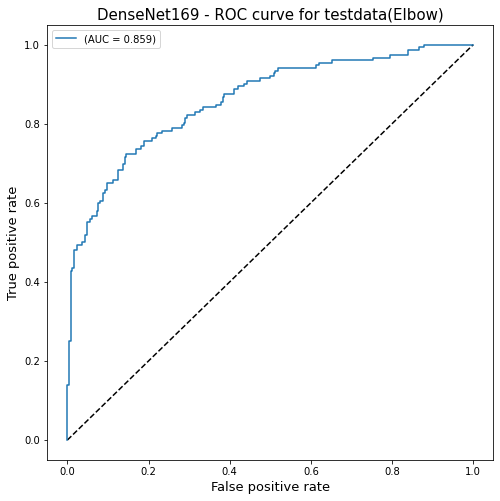

In [40]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='(AUC = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('DenseNet169 - ROC curve for testdata(Elbow)',fontsize=15)
plt.legend(loc='best')
plt.savefig(filepath+'denseroctest_elbow',dpi=300)
plt.show()

In [41]:
import cv2
def get_data():
    image_data = []
    x_data = []
    y_data = []
    for index, row in valid_df.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [43]:
testX,testY = get_data()
testY = list(map(int, testY))


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [44]:
# predict probabilities for test set
yhat_probs = model.predict(testX , verbose=0)
# predict crisp classes for test set
yhat_classes = (yhat_probs > 0.5).astype('int32')


In [45]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [46]:
print(yhat_probs)

[0.9685985  0.98919123 0.94287604 0.99467    0.99566615 0.96095437
 0.9180033  0.993028   0.3547411  0.25485033 0.10287429 0.15003653
 0.26376194 0.64924604 0.5413996  0.87255937 0.95568913 0.97146463
 0.9541579  0.9575006  0.1490278  0.7104677  0.9012506  0.676719
 0.6140047  0.7577239  0.72759104 0.25385046 0.36349726 0.2838128
 0.6483043  0.6467856  0.995808   0.9766857  0.9982805  0.9932602
 0.95521975 0.16616729 0.32847652 0.2765177  0.12915964 0.33608356
 0.3162561  0.27907905 0.35973585 0.37552598 0.9387918  0.92086494
 0.9136325  0.9351528  0.9841558  0.97272205 0.9699692  0.95433843
 0.12094428 0.43155235 0.89392525 0.92547387 0.41415417 0.2714691
 0.63041943 0.3959352  0.5268555  0.99700254 0.9933969  0.978514
 0.8339553  0.91199774 0.670596   0.8976518  0.8445779  0.9665316
 0.8808248  0.9684144  0.9912896  0.992251   0.92627    0.95303845
 0.9612605  0.9455526  0.95386356 0.97427046 0.54318625 0.6564773
 0.5590366  0.97062445 0.61402816 0.88283163 0.95286727 0.9911773
 0.98

In [47]:
print(yhat_classes)

[1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [48]:
print(testY)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [49]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [50]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.832258
Precision: 0.883838
Recall: 0.760870
F1 score: 0.817757


In [51]:
# kappa
kappa = cohen_kappa_score(testY, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testY, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testY, yhat_classes)
print(matrix)

Cohens kappa: 0.663980
ROC AUC: 0.883645
[[212  23]
 [ 55 175]]


In [52]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, yhat_probs)

In [53]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

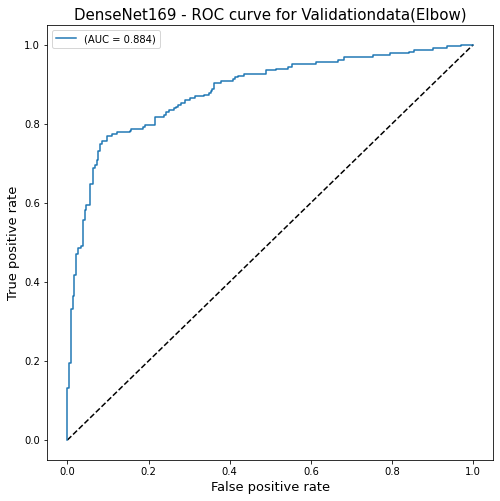

In [54]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('DenseNet169 - ROC curve for Validationdata(Elbow)',fontsize=15)
plt.legend(loc='best')
plt.savefig(filepath+'denserocvalidation_elbow',dpi=300)
plt.show()
